## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.1


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

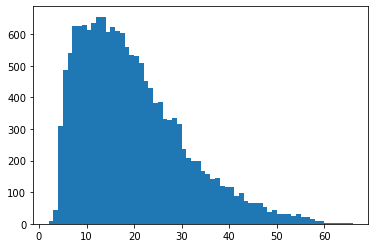

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [14]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [15]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [16]:
classes = set(labels)
print(classes)

{'love', 'sadness', 'anger', 'joy', 'surprise', 'fear'}


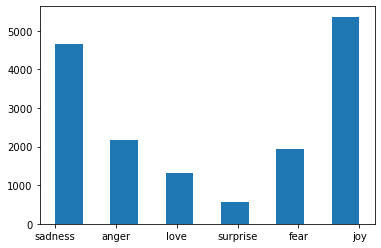

In [17]:
plt.hist(labels, bins=11)
plt.show()

In [18]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [19]:
classes_to_index

{'love': 0, 'sadness': 1, 'anger': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

In [20]:
index_to_classes

{0: 'love', 1: 'sadness', 2: 'anger', 3: 'joy', 4: 'surprise', 5: 'fear'}

In [21]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [22]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [24]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [25]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [26]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 18s 25ms/step - loss: 1.3745 - accuracy: 0.4453 - val_loss: 0.9494 - val_accuracy: 0.6605
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.6790 - accuracy: 0.7481 - val_loss: 0.6067 - val_accuracy: 0.7930
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3987 - accuracy: 0.8634 - val_loss: 0.4984 - val_accuracy: 0.8260
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2655 - accuracy: 0.9072 - val_loss: 0.4521 - val_accuracy: 0.8500
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.1900 - accuracy: 0.9382 - val_loss: 0.4496 - val_accuracy: 0.8580
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.1422 - accuracy: 0.9549 - val_loss: 0.4223 - val_accuracy: 0.8730
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1213 - accuracy: 0.9617 - val_loss: 0.4385 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

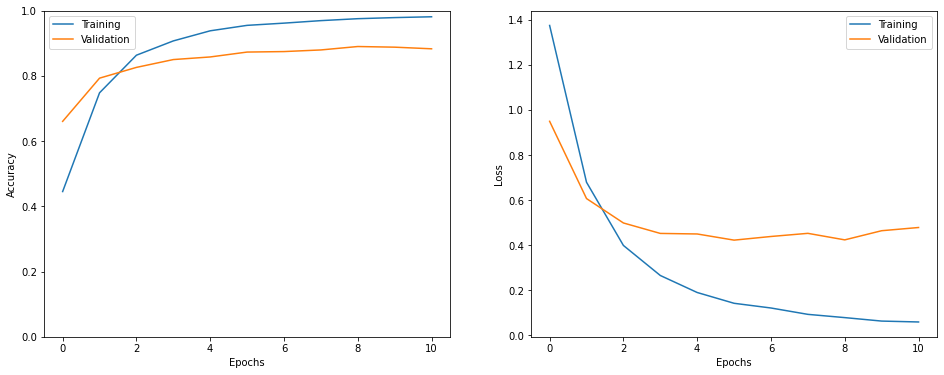

In [27]:
show_history(h)

In [28]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [29]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 8ms/step - loss: 0.4394 - accuracy: 0.8870


In [30]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
# print(p, np.argmax(p).astype('uint8'))
pred_class = index_to_classes[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i made that make me feel dumb and dumber
Emotion: sadness
1/1 [==============================] - 2s 2s/step
Predicted Emotion: sadness


In [31]:
preds = model.predict(test_sequences)
preds = np.array([np.argmax(p).astype('uint8') for p in preds])
# print(preds)
# preds.shape, test_labels.shape

63/63 [==============================] - 1s 8ms/step


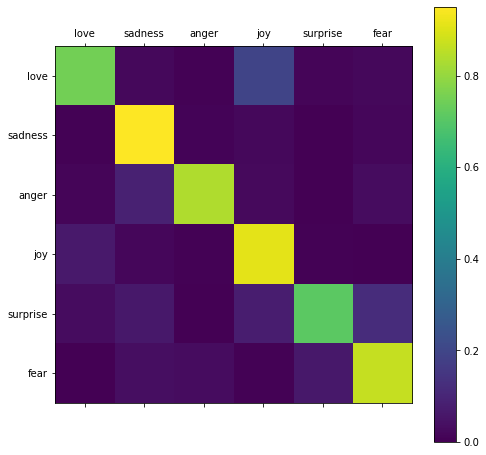

In [32]:
show_confusion_matrix(test_labels, preds, list(classes))

In [33]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds, target_names=list(classes)))

              precision    recall  f1-score   support

        love       0.69      0.75      0.72       159
     sadness       0.92      0.95      0.93       581
       anger       0.93      0.84      0.88       275
         joy       0.92      0.91      0.91       695
    surprise       0.70      0.71      0.71        66
        fear       0.86      0.87      0.86       224

    accuracy                           0.89      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000

